# **Sentiment Prediction on Movie Reviews**
## Introduction
In this notebook, we will build a machine learning model to predict the sentiment of movie reviews using Python and the provided dataset. We will utilize the libraries Scikit-learn, XGBoost, Imblearn, NumPy, Pandas, SciPy, Pickle, regex, Seaborn, Matplotlib, and LightGBM. The goal is to predict whether a review has a positive or negative sentiment.

In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Data Preparation

## Loading Data
We start by loading the necessary datasets: train.csv, test.csv, movies.csv, and sample.csv.

In [3]:
train_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')

In [4]:
test_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [5]:
movies_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

In [6]:
sample_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')

## Exploratory Data Analysis and Data Preprocessing

In [7]:
# Explore the train dataset
train_data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [8]:
# Explore the test dataset
test_data.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [9]:
# Explore the movies dataset
movies_data.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [10]:
# Explore the sample dataset
sample_data.head()

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE
2,2,NEGATIVE
3,3,NEGATIVE
4,4,NEGATIVE


In [11]:
# from sklearn.dummy import DummyClassifier

# X = train_data["reviewText"]
# y = train_data["sentiment"]

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X, y)

# DummyClassifier(strategy='most_frequent')
# dummy_clf.predict(X)

# sub = pd.DataFrame(dummy_clf.predict(test_data["reviewText"]), columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("submission.csv", encoding='utf-8')

# output = pd.read_csv("submission.csv")

In [12]:
# Check the shape of train and test datasets
print("Train dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Train dataset shape: (162758, 5)
Test dataset shape: (55315, 4)


In [13]:
# Check for missing values
print("Train dataset missing values:\n")
train_data.isnull().sum()


Train dataset missing values:



movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [14]:
print("Test dataset missing values:\n")
test_data.isnull().sum()

Test dataset missing values:



movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [15]:
print("Movies dataset missing values:\n")
movies_data.isnull().sum()

Movies dataset missing values:



movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [16]:
# Check the updated train and test dataset shape
print("Updated train dataset shape:", train_data.shape)
print("Updated test dataset shape:", test_data.shape)

Updated train dataset shape: (162758, 5)
Updated test dataset shape: (55315, 4)


In [17]:
merged_data = pd.merge(train_data, movies_data, on='movieid', how='left')

In [18]:
# Check the data types of columns in the merged dataset
data_types = merged_data.dtypes

# Filter numerical columns
numerical_columns = data_types[data_types != 'object']
numerical_columns

isFrequentReviewer       bool
audienceScore         float64
runtimeMinutes        float64
dtype: object

In [19]:
# Check for missing values in the dataset
merged_data.isnull().sum()

movieid                      0
reviewerName                 0
isFrequentReviewer           0
reviewText               23817
sentiment                    0
title                        0
audienceScore           300829
rating                  390791
ratingContents          390791
releaseDateTheaters     342951
releaseDateStreaming    275844
runtimeMinutes          222688
genre                   217333
originalLanguage        220455
director                     0
boxOffice               380216
distributor             355592
soundType               415919
dtype: int64

In [20]:
merged_data.dropna(inplace=True)

In [21]:
X = merged_data['reviewText']
y = merged_data['sentiment']

In [22]:
# Check the distribution of sentiment classes
merged_data['sentiment'].value_counts()

POSITIVE    38947
NEGATIVE    24974
Name: sentiment, dtype: int64

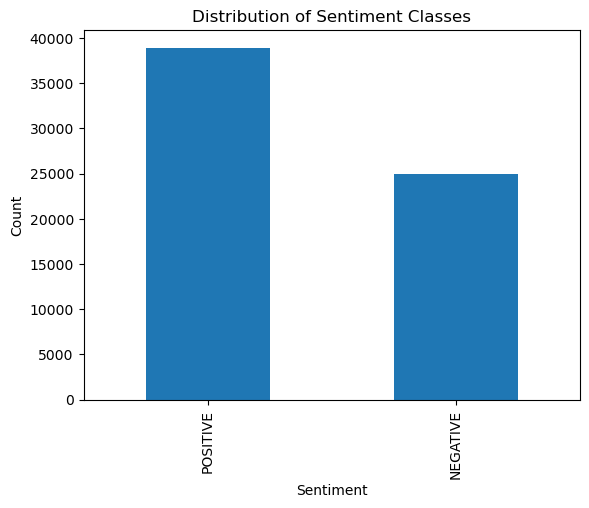

In [23]:
# Plot the distribution of sentiment classes
merged_data['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')
plt.show()

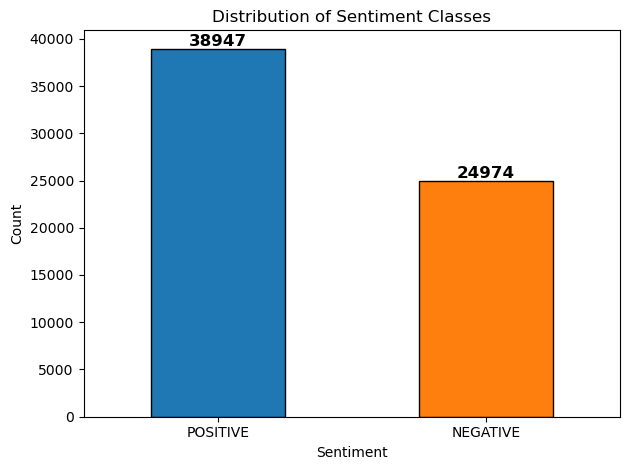

In [24]:
# Define a color palette for the plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the distribution of sentiment classes
sentiment_counts = merged_data['sentiment'].value_counts()
ax = sentiment_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1)

# Add labels to the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12, weight='bold')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')



# Rotate the x-axis labels for better readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


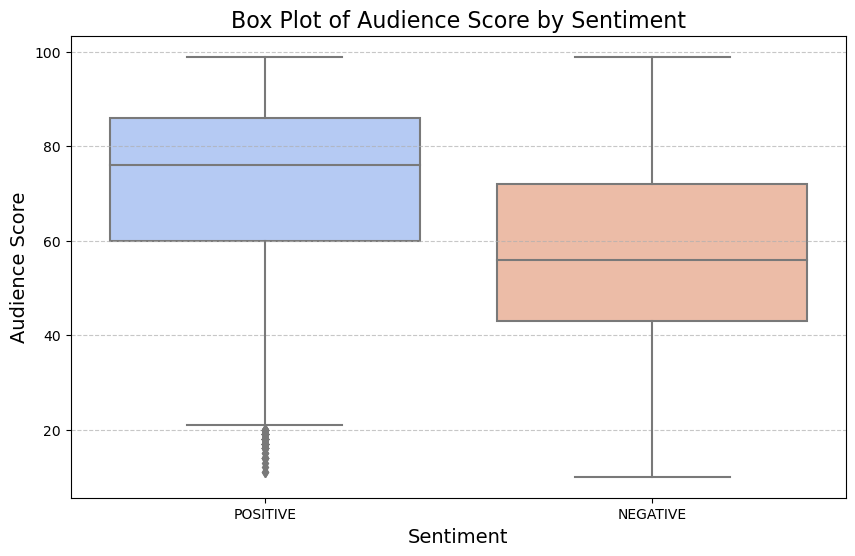

In [25]:
plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(data=merged_data, x='sentiment', y='audienceScore', palette='coolwarm', order = ['POSITIVE', 'NEGATIVE'])

# Set the labels for the x and y-axis and improve font size
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Audience Score', fontsize=14)

plt.title('Box Plot of Audience Score by Sentiment', fontsize=16)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

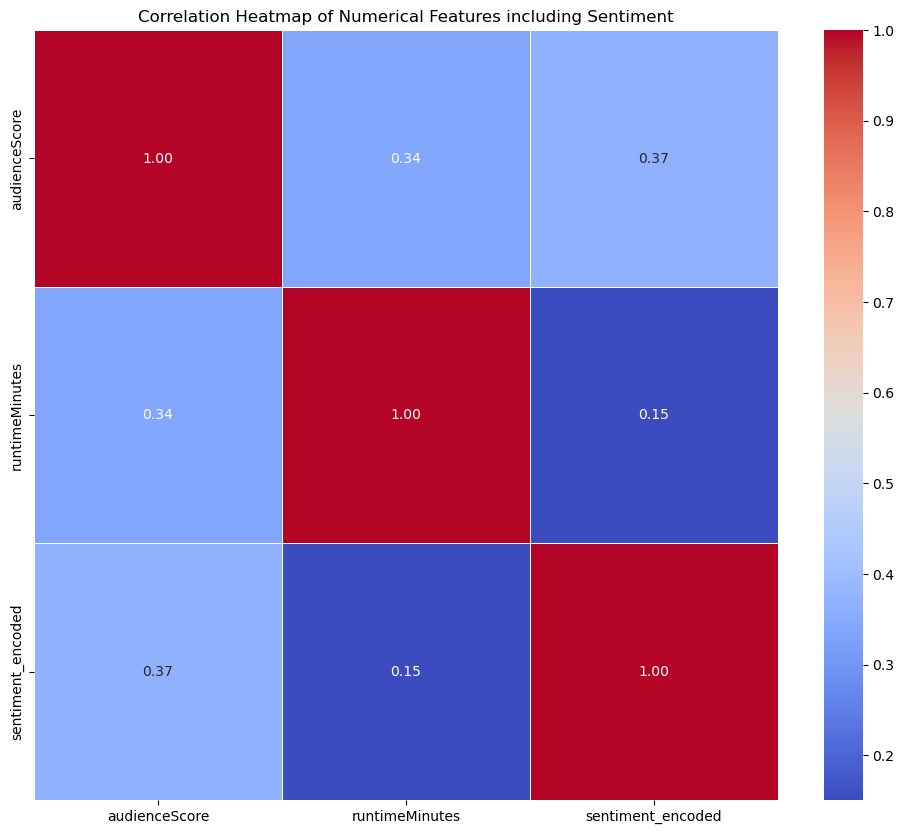

In [26]:
# Encode the sentiment labels to numerical values
sentiment_mapping = {'POSITIVE': 1, 'NEGATIVE': 0}
merged_data['sentiment_encoded'] = merged_data['sentiment'].map(sentiment_mapping)

# Select the numerical columns from the merged dataset
numerical_columns = merged_data.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Append the sentiment_encoded column to the correlation matrix
correlation_matrix['sentiment_encoded'] = correlation_matrix['sentiment_encoded'].fillna(1.0)
correlation_matrix.loc['sentiment_encoded'] = correlation_matrix['sentiment_encoded']

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features including Sentiment")
plt.show()

In [27]:
# Separate the majority and minority classes
majority_class = merged_data[merged_data['sentiment'] == 'POSITIVE']
minority_class = merged_data[merged_data['sentiment'] == 'NEGATIVE']

# Upsample the minority class to match the size of the majority class
minority_class_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine the upsampled minority class with the majority class
balanced_data = pd.concat([majority_class, minority_class_upsampled])
# Check the balanced class distribution
balanced_data['sentiment'].value_counts()

POSITIVE    38947
NEGATIVE    38947
Name: sentiment, dtype: int64

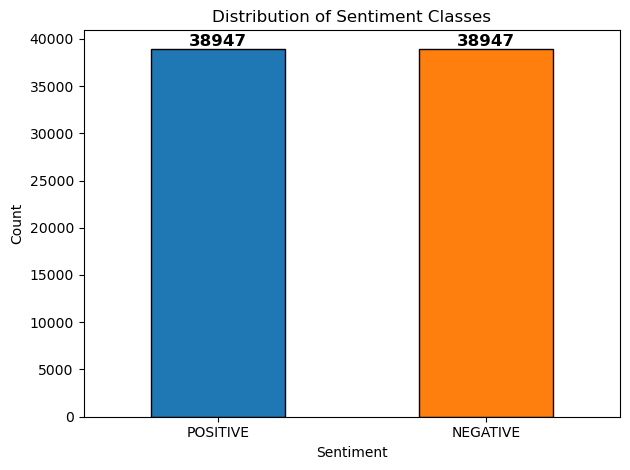

In [28]:
# Plot the distribution of sentiment classes
sentiment_counts = balanced_data['sentiment'].value_counts()
ax = sentiment_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1)

# Add labels to the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12, weight='bold')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')



# Rotate the x-axis labels for better readability
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [29]:
X = balanced_data['reviewText']
y = balanced_data['sentiment']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
import regex as re

# Convert text to lowercase
X_train = X_train.astype(str).str.lower()
X_val = X_val.astype(str).str.lower()

# Remove punctuation
X_train = X_train.apply(lambda x: re.sub(r'[^\w\s]', '', x))
X_val = X_val.apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [32]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [33]:
# vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
# X_train = vectorizer.fit_transform(X_train)
# X_val = vectorizer.transform(X_val)

In [34]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [35]:
# Print the shapes of the preprocessed data
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (62315, 49542)
X_val shape: (15579, 49542)
y_train shape: (62315,)
y_val shape: (15579,)


# Model Building

In [36]:
# # Train a LightGBM model
# lgb_model = LGBMClassifier(random_state=42)
# lgb_model.fit(X_train, y_train)

# # Predictions on validation data
# lgb_preds = lgb_model.predict(X_val)

# # Evaluate the LightGBM model
# lgb_accuracy = accuracy_score(y_val, lgb_preds)
# print("Accuracy (LightGBM):", lgb_accuracy)

In [37]:
logistic_regression_model = LogisticRegression(solver='liblinear', max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_logistic_regression_model = grid_search.best_estimator_

logistic_regression_preds = best_logistic_regression_model.predict(X_val)

logistic_regression_accuracy = accuracy_score(y_val, logistic_regression_preds)
print("Accuracy (Logistic Regression):", logistic_regression_accuracy)


logistic_regression_f1 = f1_score(y_val, logistic_regression_preds, average='weighted')
print("F1 Score (Logistic Regression):", logistic_regression_f1)

best_logistic_regression_model


Accuracy (Logistic Regression): 0.847230245843764
F1 Score (Logistic Regression): 0.8468989683830612


LogisticRegression(C=10.0, max_iter=1000, solver='liblinear')

In [38]:
# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=50)
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)

In [39]:
# # K-Nearest Neighbors (KNN)
# knn_params = {
#     'n_neighbors': [3, 5, 7, 9],
# }

# grid_search_knn = GridSearchCV(knn_model, knn_params, cv=5)
# grid_search_knn.fit(X_train_svd, y_train)
# best_knn_model = grid_search_knn.best_estimator_

# best_knn_preds = best_knn_model.predict(X_val_svd)
# best_knn_accuracy = accuracy_score(y_val, best_knn_preds)


# print("\nBest KNN Model:")
# print(best_knn_model)
# print("Accuracy:", best_knn_accuracy)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_svd, y_train)
knn_preds = knn_model.predict(X_val_svd)
knn_accuracy = accuracy_score(y_val, knn_preds)
print("Accuracy (KNN):", knn_accuracy)
knn_f1 = f1_score(y_val, knn_preds, average='weighted')
print("F1 Score (KNN):", knn_f1)

Accuracy (KNN): 0.6280890942936004
F1 Score (KNN): 0.6279889487792347


In [40]:
# svm_params = {
#     'C': [0.1, 1.0, 10.0],
#     'kernel': ['linear', 'rbf'],
# }

# grid_search_svm = GridSearchCV(svm_model, svm_params, cv=5)
# grid_search_svm.fit(X_train_svd, y_train)
# best_svm_model = grid_search_svm.best_estimator_

# best_svm_preds = best_svm_model.predict(X_val_svd)
# best_svm_accuracy = accuracy_score(y_val, best_svm_preds)

# print("\nBest SVM Model:")
# print(best_svm_model)
# print("Accuracy:", best_svm_accuracy)


# # # Support Vector Machine (SVM)
# # svm_model = SVC(kernel='linear', C=1.0)
# # svm_model.fit(X_train_svd, y_train)
# # svm_preds = svm_model.predict(X_val_svd)
# # svm_accuracy = accuracy_score(y_val, svm_preds)
# # print("Accuracy (SVM):", svm_accuracy)

In [41]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree (CART)
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)
cart_preds = cart_model.predict(X_val)

cart_accuracy = accuracy_score(y_val, cart_preds)
print("Accuracy (CART):", cart_accuracy)

Accuracy (CART): 0.8046729571859554


In [42]:

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=10)
bagging_model.fit(X_train, y_train)
bagging_preds = bagging_model.predict(X_val)
bagging_accuracy = accuracy_score(y_val, bagging_preds)
print("Accuracy (Bagging):", bagging_accuracy)

bagging_f1 = f1_score(y_val, bagging_preds, average='weighted')
print("F1 Score (Bagging):", bagging_f1)

Accuracy (Bagging): 0.8118621220874254
F1 Score (Bagging): 0.8105381259789316


In [43]:
# Boosting (AdaBoost)
boosting_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=10)
boosting_model.fit(X_train, y_train)
boosting_preds = boosting_model.predict(X_val)
boosting_accuracy = accuracy_score(y_val, boosting_preds)
print("Accuracy (AdaBoost):", boosting_accuracy)

boosting_f1 = f1_score(y_val, boosting_preds, average='weighted')
print("F1 Score (AdaBoost):", boosting_f1)

Accuracy (AdaBoost): 0.8118621220874254
F1 Score (AdaBoost): 0.8111190764539612


In [44]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print("Accuracy (Random Forest):", rf_accuracy)

random_forest_f1 = f1_score(y_val, rf_preds, average='weighted')
print("F1 Score (Random Forest):", random_forest_f1)

Accuracy (Random Forest): 0.72649078888247
F1 Score (Random Forest): 0.7264947646630626


In [45]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_val)
gb_accuracy = accuracy_score(y_val, gb_preds)
print("Accuracy (Gradient Boosting):", gb_accuracy)

gradient_boosting_f1 = f1_score(y_val, gb_preds, average='weighted')
print("F1 Score (Gradient Boosting):", gradient_boosting_f1)

Accuracy (Gradient Boosting): 0.6529302265870723
F1 Score (Gradient Boosting): 0.652717926669356


In [46]:
# from sklearn.neural_network import MLPClassifier

# # # Multi-Layer Perceptron (MLP)
# # mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
# # mlp_model.fit(X_train, y_train)
# # mlp_preds = mlp_model.predict(X_val)
# # mlp_accuracy = accuracy_score(y_val, mlp_preds)
# # print("Accuracy (MLP):", mlp_accuracy)

# mlp_params = {
#     'hidden_layer_sizes': [(100,), (100, 50), (150, 100)],
#     'activation': ['relu', 'tanh'],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
# }

# # Create the MLP classifier
# mlp_model = MLPClassifier(max_iter=500, random_state=42)


# grid_search_mlp = GridSearchCV(mlp_model, mlp_params, cv=5)
# grid_search_mlp.fit(X_train, y_train)
# best_mlp_model = grid_search_mlp.best_estimator_


# # Evaluate the best MLP model on the validation set
# best_mlp_preds = best_mlp_model.predict(X_val)
# best_mlp_accuracy = accuracy_score(y_val, best_mlp_preds)

# # Print the best hyperparameters and accuracy
# print("Best MLP Model:")
# print(best_mlp_model)
# print("Accuracy:", best_mlp_accuracy)

In [47]:
#Multi-Layer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)

mlp_accuracy = accuracy_score(y_val, mlp_preds)
print("Accuracy (MLP):", mlp_accuracy)

mlp_f1 = f1_score(y_val, mlp_preds, average='weighted')
print("F1 Score (MLP):", mlp_f1)

Accuracy (MLP): 0.8708517876628795
F1 Score (MLP): 0.8707096317900794


# Model Selection

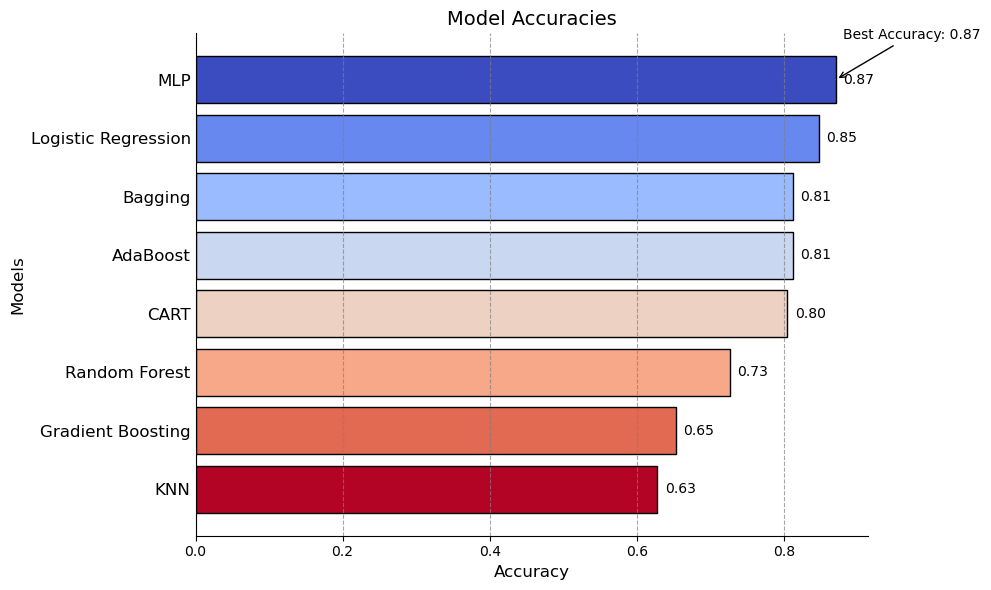


Best Model: MLP
Accuracy: 0.8708517876628795


In [48]:

# Sample data for demonstration purposes
model_accuracies = {
    'Logistic Regression': logistic_regression_accuracy,
    'KNN': knn_accuracy,
#     'SVM': svm_accuracy,
    'CART': cart_accuracy,
    'Bagging': bagging_accuracy,
    'AdaBoost': boosting_accuracy,
    'MLP': mlp_accuracy,
    'Random Forest': rf_accuracy,
    'Gradient Boosting': gb_accuracy    
}

best_model = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model]

# Sort the models and accuracies in descending order based on accuracy
sorted_accuracies = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*sorted_accuracies)

# Plotting the horizontal clustered bar chart
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(models))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(models)))  # Diverging color map
ax.barh(y_pos, accuracies, align='center', color=colors, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(models, fontsize=12)  # Increase font size for y-axis labels
ax.invert_yaxis()  # Invert the y-axis to show the highest accuracy at the top
ax.set_xlabel('Accuracy', fontsize=12)  # Increase font size for x-axis label
ax.set_ylabel('Models', fontsize=12)  # Increase font size for y-axis label
ax.set_title('Model Accuracies', fontsize=14)  # Increase font size for title

# Annotate the best accuracy on the plot
ax.annotate(f"Best Accuracy: {best_accuracy:.2f}", xy=(best_accuracy, y_pos[0]),
             xytext=(best_accuracy + 0.01, y_pos[0] - 0.7),  # Adjust the annotation position
             arrowprops=dict(arrowstyle='->'))


# Add percentage labels on the bars
for i, v in enumerate(accuracies):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=10)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks on the y-axis
ax.tick_params(axis='y', length=0)

# Add a horizontal grid for better readability
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Adjust the space between bars for better spacing
plt.subplots_adjust(left=0.2)

# Show the plot
plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model}")
print(f"Accuracy: {best_accuracy}")


# Ensemble Approaches 
We create a Stacking Ensemble model using the best models and a meta-classifier.

In [49]:
# Create the Stacking Ensemble classifier with Logistic Regression as the meta-classifier
stacking_model = StackingClassifier(
    estimators=[
        ('lr', best_logistic_regression_model),
        ('bagging', bagging_model),
        ('boosting', boosting_model),
        ('cart',cart_model),
        ('mlp', mlp_model)
    ],
    final_estimator=mlp_model,
    stack_method='predict_proba',  # Use 'predict_proba' to enable probabilities for meta-classifier
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the Stacking Ensemble model on the training data
stacking_model.fit(X_train, y_train)

# Make predictions on the validation data using the Stacking Ensemble model
stacking_preds = stacking_model.predict(X_val)

# Evaluate the accuracy of the Stacking Ensemble model
stacking_accuracy = accuracy_score(y_val, stacking_preds)
print("Accuracy (Stacking Ensemble):", stacking_accuracy)

stacking_f1_micro = f1_score(y_val, stacking_preds, average='micro')
print("F1 Score (Stacking Ensemble - Micro):", stacking_f1_micro)

Accuracy (Stacking Ensemble): 0.8883111881378779
F1 Score (Stacking Ensemble - Micro): 0.8883111881378779


In [50]:
print("Classification Report (Stacking Ensemble):\n", classification_report(y_val, stacking_preds))

Classification Report (Stacking Ensemble):
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      7875
           1       0.86      0.92      0.89      7704

    accuracy                           0.89     15579
   macro avg       0.89      0.89      0.89     15579
weighted avg       0.89      0.89      0.89     15579



In [51]:
# Print the confusion matrix for the Stacking Classifier
conf_matrix = confusion_matrix(y_val, stacking_preds)
print("Confusion Matrix (Stacking Ensemble):\n", conf_matrix)

Confusion Matrix (Stacking Ensemble):
 [[6751 1124]
 [ 616 7088]]


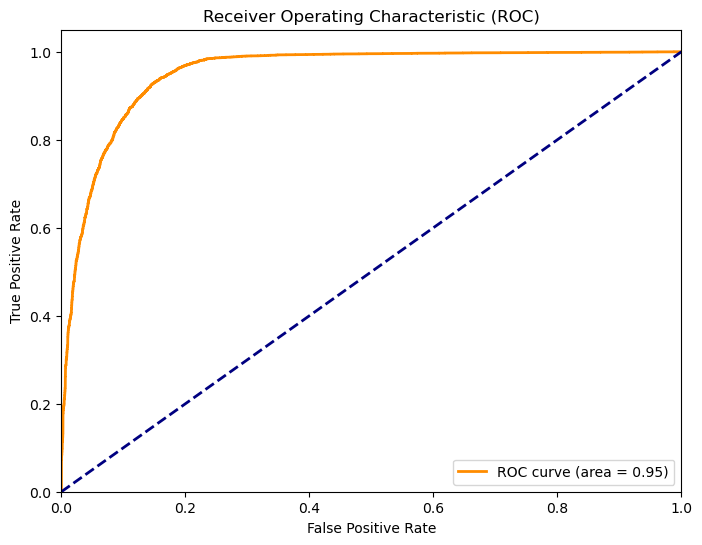

In [52]:
# Calculate ROC curve and ROC AUC score for the Stacking Classifier
y_scores_stacking = stacking_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_scores_stacking)
roc_auc = roc_auc_score(y_val, y_scores_stacking)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [53]:
# def ensemble_voting(predictions):
#     voted_preds = []
#     for i in range(len(predictions[0])):
#         votes = [pred[i] for pred in predictions]
#         voted_preds.append(max(set(votes), key=votes.count))
#     return voted_preds

In [54]:
# ensemble_preds = ensemble_voting([logistic_regression_preds, boosting_preds, mlp_preds])

In [55]:
# ensemble_accuracy = accuracy_score(y_val, ensemble_preds)
# print("Accuracy (Ensemble Voting):", ensemble_accuracy)

In [56]:
# Preprocess the test data
X_test = test_data['reviewText'].astype(str).str.lower()
X_test = X_test.apply(lambda x: re.sub(r'[^\w\s]', '', x))
X_test = vectorizer.transform(X_test)

# Make predictions on the test data using the best model
test_preds = stacking_model.predict(X_test)

# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id': sample_data['id'], 'sentiment': test_preds})

# Map the encoded labels back to their original values
submission_df['sentiment'] = label_encoder.inverse_transform(submission_df['sentiment'])

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
